# Goal

Make the regions to choose from in `regionmask` more modular.

Currently, NaturalEarth, Giorgi and SREX regions included. However, there are masses of shapefiles out there to be used.

- Challenge: no nice download API like for NaturalEarth, often need to agree to not store shapefile somewhere online
- Solution: Download from link (all metadata managed in yaml); if breaks, advise user to do manually with explanation (needed for Marine Regions)

This notebooks scetches how to include these resources into the source code of `regionmask`:
    - http://maps.tnc.org/gis_data.html
        - TEOW
        - MEOW
        - FEOW
    - https://www.marineregions.org/downloads.php:
        - LME
        - Longhurst



In [1]:
import regionmask
import xarray as xr
import numpy as np
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline
regionmask.__version__

'0.5.0+dev'

In [2]:
# large plotting regime
plt.rcParams['figure.figsize'] = (40, 7)

Most shapefiles follow similar conventions when opened with `geopandas` (See below under section `Old`). Those can be used to create `regionmask.Regions`:
- outlines are stored in 'geometry'
- number_col
- name_col
- abbrev_col needs to be created

In [3]:
def create_region_from_shapefile(shapefile, name_col, number_col=None,abbrev_col=None, **Regions_kwargs):
    """Helper function to create `regionmask.Regions`.
    
    Parameters
    ----------
    shapefile : geopandas.geodataframe.GeoDataFrame
        Shapefile to be downloaded. File has extensions .shp.
    name_col : str
        Name of the column in shapefile that names a region.
    number_col : str (optional)
        Number of the column in shapefile that gives a region its number.
        This column shouldnt have duplicates. If None (default), takes shapefile.index.
    abbrev_col : str (optional)
        Abbreviation of the column in shapefile that five a region its abbreviation.
        If None (default), a combination of the first letters of region name is taken.
    **Region_kwargs: dict
        see regionmask.Regions: source, name
    
    Returns
    -------
    regionmask.core.regions.Regions

    """
    mask = shapefile.copy()
    # number of region
    if number_col is not None:
        # sort, otherwise breaks
        mask = mask.sort_values(number_col)
        # ensure integer
        mask[number_col] = mask[number_col].astype('int')
        numbers = mask[number_col].values
    else:
        numbers = mask.index.values
    # if no abbrev column name is give, create them from name
    # todo: make this more robust
    if abbrev_col == None:
        abbrevs=[]
        for item in mask.T:
            #print(item)
            name_for_abbrev = mask.loc[item][name_col]
            # catch region with no name
            if name_for_abbrev is None:
                name_for_abbrev = 'UND' # for undefined
            abbrev = "".join(word[0] for word in name_for_abbrev.split(' '))
            abbrevs.append(abbrev)
    else:
        abbrevs = mask[abbrev_col].values
    # polynoms/outlines are always stored as geometry
    polynoms = mask['geometry'].values
    # names of the regions
    names = mask[name_col].values

    return regionmask.Regions(polynoms, numbers, names, abbrevs, **Regions_kwargs)

In [4]:
import os
import yaml
import geopandas
import zipfile

### download

In [5]:
import requests

def is_downloadable(url):
    """
    Does the url contain a downloadable resource
    """
    h = requests.head(url, allow_redirects=True)
    header = h.headers
    content_type = header.get('content-type')
    if 'text' in content_type.lower():
        return False
    if 'html' in content_type.lower():
        return False
    return True

In [6]:
url='http://maps.tnc.org/files/shp/MEOW-TNC.zip'
is_downloadable(url)

True

In [7]:
def download(url,destination):
    r = requests.get(url, allow_redirects=True)
    open(destination, 'wb').write(r.content)
    return

#### extract if zip

In [8]:
def unzip(filename_str):
    zip_ref = zipfile.ZipFile(filename_str, 'r')
    zip_ref.extractall(filename_str.strip('.zip'))
    zip_ref.close()

## regionmask cache folder

In [9]:
_default_cache_dir = os.sep.join(('~', '.regionmask_data'))
longdir = os.path.expanduser(_default_cache_dir)

## get info from yaml

In [10]:
fn="download_regions.yaml"
with open(fn, 'r') as f:
    metadata = yaml.safe_load(f)
    keywords_dict = {}
    for k, v in metadata.items():
        for keyword in v['keywords']:
            keywords_dict.update({keyword: k})

In [11]:
keywords_dict

{'MEOW': 'MEOW',
 'meow': 'MEOW',
 'Marine_Ecoregions_Of_the_World': 'MEOW',
 'FEOW': 'FEOW',
 'feow': 'FEOW',
 'Freshwater_Ecoregions_Of_the_World': 'FEOW',
 'TerrEcos': 'TEOW',
 'terrecos': 'TEOW',
 'Terrestrial_Ecoregions_Of_the_World': 'TEOW',
 'TEOW': 'TEOW',
 'lme': 'LME',
 'LMEs': 'LME',
 'lmes': 'LME',
 'LME': 'LME',
 'Large_Marine_Ecosystems': 'LME',
 'Longhurst': 'Longhurst'}

In [12]:
# storing info from yaml in download_regions_config dict
with open(fn) as f:
    download_regions_config = yaml.safe_load(f)
f.close()

In [13]:
# setting no value is equal to setting None
download_regions_config['LME']['download']['url'] is None

True

In [14]:
def download_dataset(dataset_key):
    """Download a dataset given by dataset_key."""
    url = download_regions_config[dataset_key]['download']['url']
    if download_regions_config[dataset_key]['download']['url'] is None:
        print(download_regions_config[dataset_key]['download']['manually'])
    else:
        assert is_downloadable(url)

    file_name = url.split('/')[-1]
    
    destination = f'{longdir}/{file_name}'
    download(url,destination)
    
    file_extension = file_name.split('.')[-1]
    
    if file_extension in ['zip']:
        print('unzip')
        unzip(destination)
        print('remove zip')
        os.remove(destination)
    return

In [15]:
def build_region(dataset_key):
    """Build a pre-defined region in download_regions.yaml.
    
    Parameters
    ----------
    dataset_key : str
        String of dataset. Keywords from download_regions are also allowed.
    
    Returns
    -------
    regionmask.core.regions.Regions

    """
    # convert keyword to real dataset key
    if dataset_key not in keywords_dict:
        raise ValueError(f"{dataset_key} not found in keywords: Please select from {keywords_dict.keys()}.")
    dataset_key = keywords_dict[dataset_key]
    
    shapefile_args=download_regions_config[dataset_key]['create_region_from_shapefile_args']
    shp_file_str=shapefile_args['shp_file_str']
    shp_file_str_long = f'{longdir}/{shp_file_str}'
    # download shapefile if not in longdir
    if not os.path.exists(shp_file_str_long):
        url = download_regions_config[dataset_key]['download']['url']
        # aim to download from url given in yaml
        if url != 'None':
            download_dataset(dataset_key=dataset_key)
            print(f"Download dataset {dataset_key} from website {download_regions_config[dataset_key]['website']} url {download_regions_config[dataset_key]['download']['url']}.")
        # if no downloadable url is present in yaml, print message to download manually
        else:
            raise ValueError(f"Dataset {dataset_key} cannot be automatically downloaded. Please follw these instructions."
                  f"{download_regions_config[dataset_key]['download']['manually']}. "
                  f"Then unzip if needed and ensure that ~/.regionmask_data/{shapefile_args['shp_file_str']} exists.")
    # open shapefile
    shp = geopandas.read_file(shp_file_str_long)
    # handle not required args
    abbrev_col = shapefile_args['abbrev_col'] if 'abbrev_col' in shapefile_args else None
    # create region
    new_region = create_region_from_shapefile(shp,name=shapefile_args['name'],
                                              name_col=shapefile_args['name_col'],
                                              number_col=shapefile_args['number_col'],
                                              abbrev_col=abbrev_col,
                                             )
    return new_region

In [16]:
MEOW_region = build_region(dataset_key='MEOW')

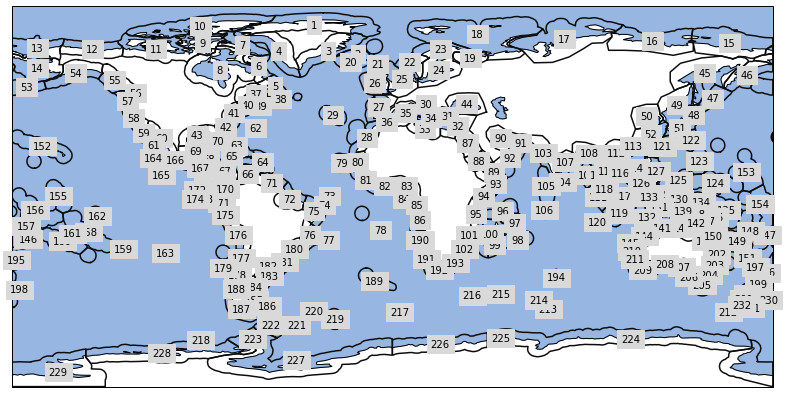

In [17]:
MEOW_region.plot()

In [18]:
type(build_region(dataset_key='TEOW'))

regionmask.core.regions.Regions


 Test MEOW
{'keywords': ['MEOW', 'meow', 'Marine_Ecoregions_Of_the_World'], 'long_name': 'Marine Ecoregions Of the World', 'website': 'http://maps.tnc.org/gis_data.html', 'download': {'url': 'http://maps.tnc.org/files/shp/MEOW-TNC.zip'}, 'metadata': 'http://maps.tnc.org/files/metadata/MEOW.xml', 'description': "The Marine Ecoregions Of the World (MEOW) data set is a biogeographic classification of the world's coasts and shelves. The ecoregions nest within the broader biogeographic tiers of Realms and Provinces. Further details about the MEOW system and PDFs of the BioScience paper the comprehensive listing of sources are available from www.worldwildlife.org/MEOW/ and www.nature.org/MEOW.", 'create_region_from_shapefile_args': {'name': 'MEOW', 'name_col': 'ECOREGION', 'number_col': 'ECO_CODE_X', 'shp_file_str': 'MEOW-TNC/meow_ecos.shp'}}


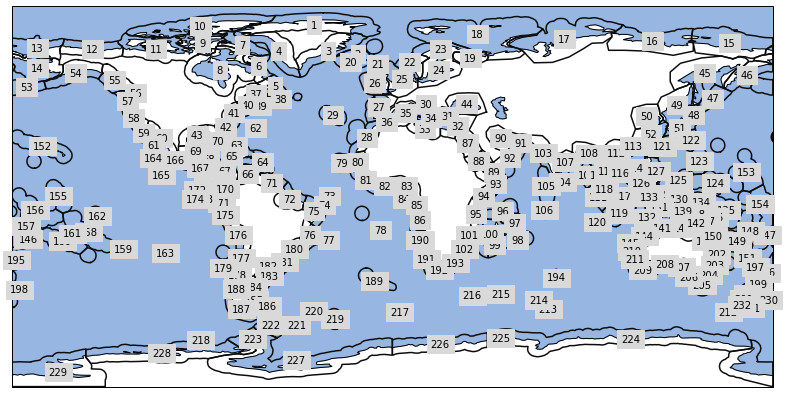


 Test Marine_Ecoregions_Of_the_World
{'keywords': ['MEOW', 'meow', 'Marine_Ecoregions_Of_the_World'], 'long_name': 'Marine Ecoregions Of the World', 'website': 'http://maps.tnc.org/gis_data.html', 'download': {'url': 'http://maps.tnc.org/files/shp/MEOW-TNC.zip'}, 'metadata': 'http://maps.tnc.org/files/metadata/MEOW.xml', 'description': "The Marine Ecoregions Of the World (MEOW) data set is a biogeographic classification of the world's coasts and shelves. The ecoregions nest within the broader biogeographic tiers of Realms and Provinces. Further details about the MEOW system and PDFs of the BioScience paper the comprehensive listing of sources are available from www.worldwildlife.org/MEOW/ and www.nature.org/MEOW.", 'create_region_from_shapefile_args': {'name': 'MEOW', 'name_col': 'ECOREGION', 'number_col': 'ECO_CODE_X', 'shp_file_str': 'MEOW-TNC/meow_ecos.shp'}}


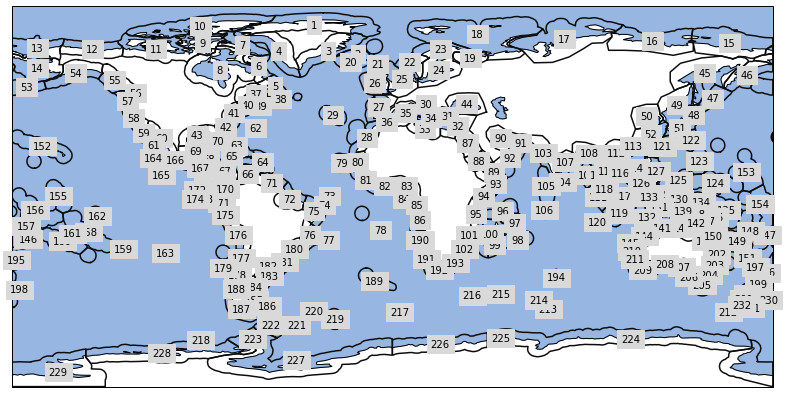


 Test FEOW
{'keywords': ['FEOW', 'feow', 'Freshwater_Ecoregions_Of_the_World'], 'long_name': 'Freshwater Ecoregions Of the World', 'website': 'http://maps.tnc.org/gis_data.html', 'download': {'url': 'http://maps.tnc.org/files/shp/FEOW-TNC.zip'}, 'metadata': 'http://maps.tnc.org/files/metadata/FEOW.xml', 'description': "The Freshwater Ecoregions Of the World (FEOW) provide a global biogeographic regionalization of the Earth's freshwater biodiversity. This version of the FEOW, modified by The Nature Conservancy, includes additional tabular data describing Major Habitat Types (MHTs, similar to terrestrial biomes, but unpublished).You can read more about the FEOW, and obtain the unmodified shapefile at www.feow.org.", 'create_region_from_shapefile_args': {'name': 'FEOW', 'name_col': 'ECOREGION', 'number_col': 'ECO_ID', 'shp_file_str': 'FEOW-TNC/FEOWv1_TNC.shp'}}


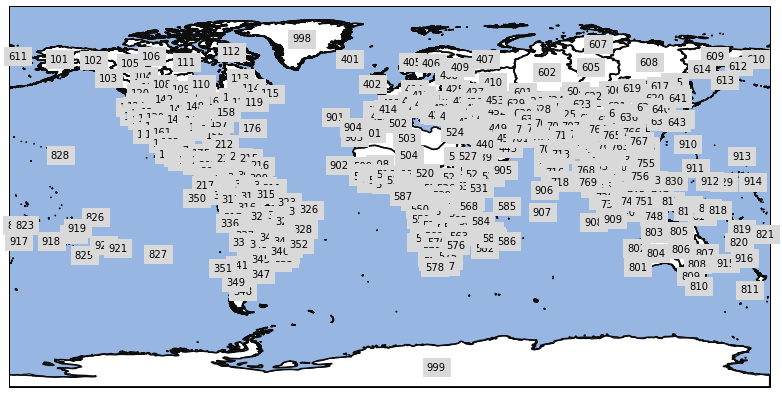


 Test LME
{'keywords': ['lme', 'LMEs', 'lmes', 'LME', 'Large_Marine_Ecosystems'], 'long_name': 'Marine Ecoregions Of the World', 'website': 'http://maps.tnc.org/gis_data.html', 'download': {'url': None, 'manually': 'Click on LME66.zip on https://www.sciencebase.gov/catalog/item/55c77722e4b08400b1fd8244.'}, 'metadata': None, 'description': 'Large Marine Ecosystems (LMEs) are relatively large areas of ocean space of approximately 200,000 sq km; or greater, adjacent to the continents in coastal waters where primary productivity is generally higher than in open ocean areas.', 'create_region_from_shapefile_args': {'name': 'LME', 'name_col': 'LME_NAME', 'number_col': 'OBJECTID', 'shp_file_str': 'LME66/LMEs66.shp'}}


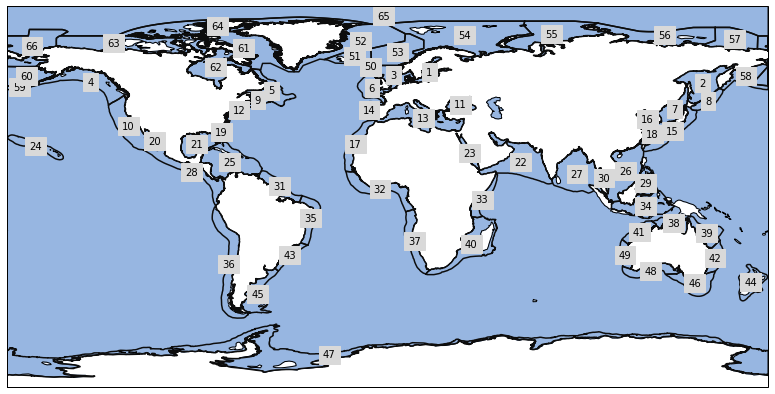


 Test Longhurst
{'keywords': ['Longhurst'], 'long_name': 'Longhurst regions', 'website': None, 'download': {'url': None, 'manually': 'Download Version 4 from https://www.marineregions.org/downloads.php#longhurst.'}, 'create_region_from_shapefile_args': {'name': 'Longhurst', 'name_col': 'ProvDescr', 'number_col': None, 'abbrev_col': 'ProvCode', 'shp_file_str': 'longhurst_v4_2010/Longhurst_world_v4_2010.shp'}}


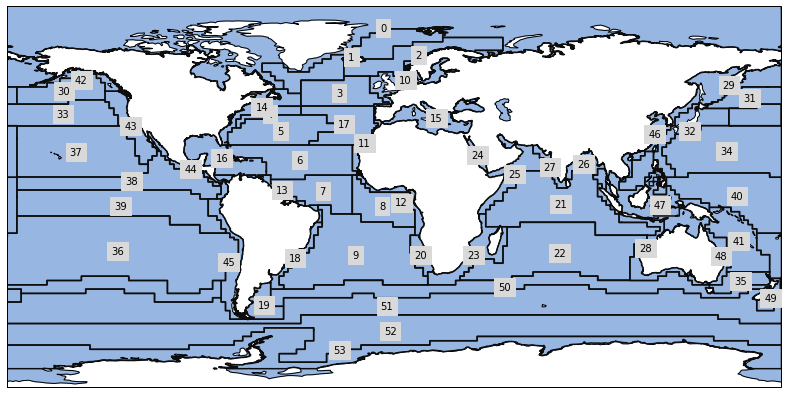


 Test TEOW
{'keywords': ['TerrEcos', 'terrecos', 'Terrestrial_Ecoregions_Of_the_World', 'TEOW'], 'long_name': 'Terrestrial Ecoregions Of the World', 'website': 'http://maps.tnc.org/gis_data.html#TerrEcos', 'download': {'url': 'http://maps.tnc.org/files/shp/terr-ecoregions-TNC.zip'}, 'metadata': 'http://maps.tnc.org/files/metadata/TerrEcos.xml', 'description': "This is the master spatial data layer for TNC's terrestrial ecoregions of the world, exported from the geodatabase listed above. Note that it includes Mangroves, Inland Water, and Rock and Ice MHTs, although they are not being handled by terrestrial assessments. This layer is based on WWF's ecoregions outside the United States, and loosely based on Bailey's ecoregions (from the USDA Forest Service) within the United States.", 'create_region_from_shapefile_args': {'name': 'TEOW', 'name_col': 'ECO_NAME', 'number_col': 'ECO_ID_U', 'shp_file_str': 'terr-ecoregions-TNC/tnc_terr_ecoregions.shp'}}


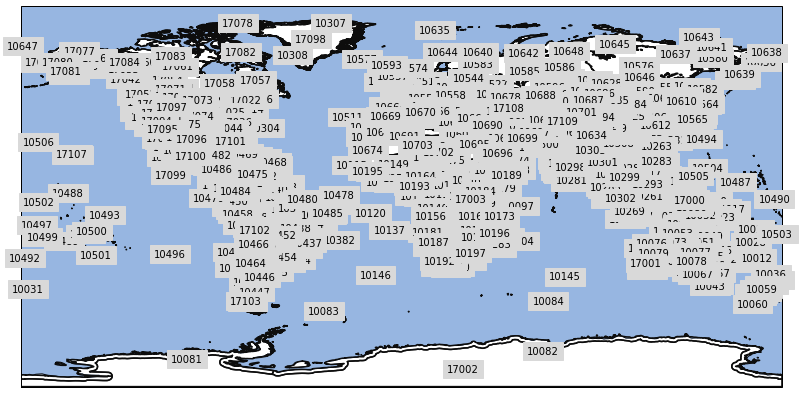

In [19]:
for dataset_key in ['MEOW','Marine_Ecoregions_Of_the_World','FEOW','LME','Longhurst','TEOW']:
    print(f'\n Test {dataset_key}')
    try:
        dataset_key = keywords_dict[dataset_key]
        print(download_regions_config[dataset_key])
        build_region(dataset_key=dataset_key).plot()
        plt.show()
    except Exception as e:
        print(f'Failed {e}')

# old
exploring manually

## Longhurst
https://www.marineregions.org/downloads.php#longhurst

In [20]:
shp_file_str = 'longhurst_v4_2010/Longhurst_world_v4_2010.shp'

In [21]:
longhurst_shp = geopandas.read_file(shp_file_str)
longhurst_shp.index.size
longhurst_shp.head()

,ProvCode,ProvDescr,geometry
0,BPLR,Polar - Boreal Polar Province (POLR),(POLYGON ((-161.1842555150782 63.4999999999998...
1,ARCT,Polar - Atlantic Arctic Province,(POLYGON ((-21.51305083678631 64.6440941479561...
2,SARC,Polar - Atlantic Subarctic Province,"(POLYGON ((11.2647152221077 63.96082319213352,..."
3,NADR,Westerlies - N. Atlantic Drift Province (WWDR),POLYGON ((-11.49999999999989 57.50000000000006...
4,GFST,Westerlies - Gulf Stream Province,"POLYGON ((-43.5 43.50000000000003, -43.5 42.50..."


In [22]:
type(longhurst_shp)

geopandas.geodataframe.GeoDataFrame

In [23]:
Lunghurst_mask = create_region_from_shapefile(longhurst_shp, name='Longhurst', name_col='ProvDescr', number_col=None,abbrev_col='ProvCode')

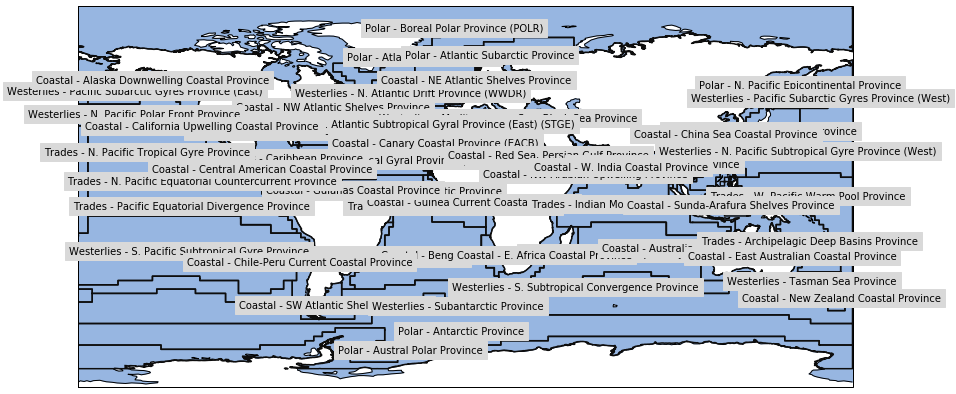

In [24]:
Lunghurst_mask.plot(label='name')

## LME
https://www.sciencebase.gov/catalog/item/55c77722e4b08400b1fd8244

In [25]:
# doesnt work
# !wget http://lme.edc.uri.edu/images/Content/Downloads/DigitalData/LME66.zip

In [26]:
shp_file_str = 'LME66/LMEs66.shp'

In [27]:
LME_shp = geopandas.read_file(shp_file_str)
LME_shp.index.size
LME_shp.head()

,OBJECTID,LME_NUMBER,LME_NAME,GROUPING,ARCTIC,USLMES,Shape_Leng,Shape_Area,SUM_GIS_KM,geometry
0,1,23.0,Baltic Sea,None,None,None,219.326402,61.950021,3.951472e+05,"POLYGON ((10.97943973554271 54.38055038418429,..."
1,2,52.0,Sea of Okhotsk,None,None,None,145.932989,213.796584,1.561297e+06,"POLYGON ((156.7070450503869 51.18857905056069,..."
2,3,22.0,North Sea,None,None,None,209.486403,103.965247,6.938472e+05,"POLYGON ((5.278888225314518 61.98027038609212,..."
3,4,2.0,Gulf of Alaska,None,None,Yes,495.473780,211.045622,1.530668e+06,POLYGON ((-149.4114074707736 61.49637985210421...
4,5,9.0,Labrador - Newfoundland,Arctic,Arctic,None,270.847479,114.597691,9.077923e+05,(POLYGON ((-64.56793350674803 60.4550934642860...


In [28]:
#todo: should be used but doesnt work
# number_col = 'LME_NUMBER'

In [29]:
LME_mask = create_region_from_shapefile(LME_shp, name='LME', name_col='LME_NAME', number_col='OBJECTID',abbrev_col=None)

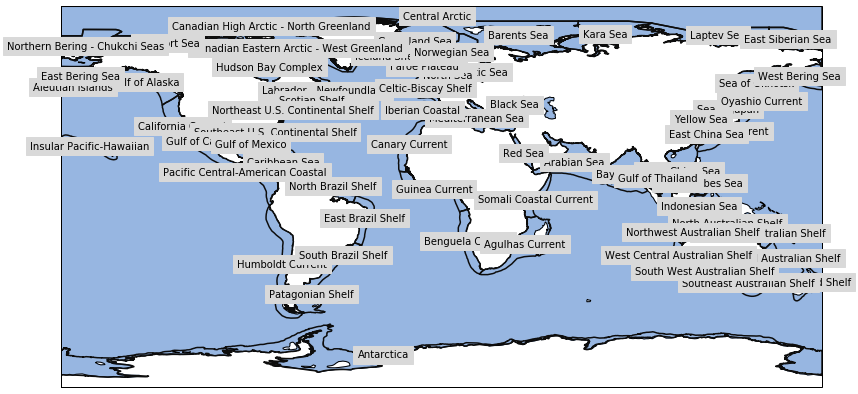

In [30]:
LME_mask.plot(label='name')

In [31]:
mask = LME_shp
number_col = 'OBJECTID'
mask = mask.sort_values(number_col)

In [32]:
numbers = mask[number_col].values
numbers

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [33]:
name_col='LME_NAME'
names = mask[name_col].values
names

array(['Baltic Sea', 'Sea of Okhotsk', 'North Sea', 'Gulf of Alaska',
       'Labrador - Newfoundland', 'Celtic-Biscay Shelf', 'Sea of Japan',
       'Oyashio Current', 'Scotian Shelf', 'California Current',
       'Black Sea', 'Northeast U.S. Continental Shelf',
       'Mediterranean Sea', 'Iberian Coastal', 'Kuroshio Current',
       'Yellow Sea', 'Canary Current', 'East China Sea',
       'Southeast U.S. Continental Shelf', 'Gulf of California',
       'Gulf of Mexico', 'Arabian Sea', 'Red Sea',
       'Insular Pacific-Hawaiian', 'Caribbean Sea', 'South China Sea',
       'Bay of Bengal', 'Pacific Central-American Coastal',
       'Sulu-Celebes Sea', 'Gulf of Thailand', 'North Brazil Shelf',
       'Guinea Current', 'Somali Coastal Current', 'Indonesian Sea',
       'East Brazil Shelf', 'Humboldt Current', 'Benguela Current',
       'North Australian Shelf', 'Northeast Australian Shelf',
       'Agulhas Current', 'Northwest Australian Shelf',
       'East Central Australian Shelf', 

In [34]:
abbrevs=[]
for item in mask.T:
    #print(item)
    abbrevs.append("".join(word[0] for word in mask.loc[item][name_col].split(' ')))

np.array(abbrevs)

array(['BS', 'SoO', 'NS', 'GoA', 'L-N', 'CS', 'SoJ', 'OC', 'SS', 'CC',
       'BS', 'NUCS', 'MS', 'IC', 'KC', 'YS', 'CC', 'ECS', 'SUCS', 'GoC',
       'GoM', 'AS', 'RS', 'IP', 'CS', 'SCS', 'BoB', 'PCC', 'SS', 'GoT',
       'NBS', 'GC', 'SCC', 'IS', 'EBS', 'HC', 'BC', 'NAS', 'NAS', 'AC',
       'NAS', 'ECAS', 'SBS', 'NZS', 'PS', 'SAS', 'A', 'SWAS', 'WCAS',
       'FP', 'ISaS', 'GS', 'NS', 'BS', 'KS', 'LS', 'ESS', 'WBS', 'AI',
       'EBS', 'CEA-WG', 'HBC', 'BS', 'CHA-NG', 'CA', 'NB-CS'], dtype='<U6')

In [35]:
polynoms=mask['geometry'].values

In [37]:
LME_mask = regionmask.Regions(polynoms, numbers, names, abbrevs, name='LME')

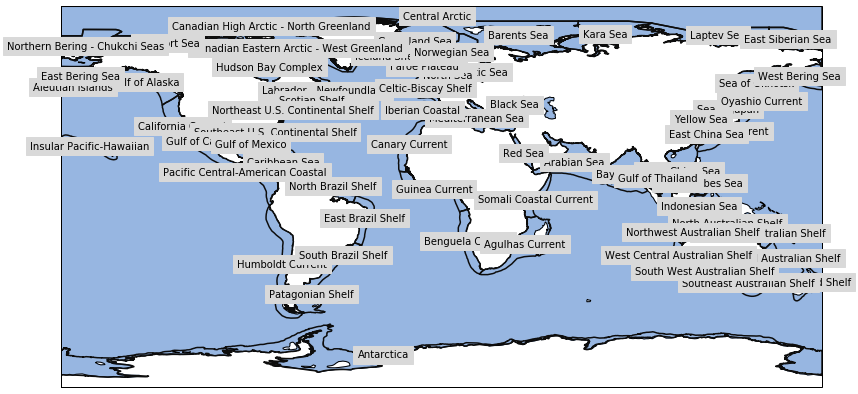

In [39]:
LME_mask.plot(label='name')

## Terrestrial Ecoregions

In [ ]:
# from http://maps.tnc.org/gis_data.html#TerrEcos

In [ ]:
# wget http://maps.tnc.org/files/shp/terr-ecoregions-TNC.zip

In [40]:
TerrEcos_shapefile = geopandas.read_file('terr-ecoregions-TNC/tnc_terr_ecoregions.shp')
TerrEcos_shapefile.head()

,ECO_ID_U,ECO_CODE,ECO_NAME,ECO_NUM,ECODE_NAME,CLS_CODE,ECO_NOTES,WWF_REALM,WWF_REALM2,WWF_MHTNUM,WWF_MHTNAM,RealmMHT,ER_UPDATE,ER_DATE_U,ER_RATION,SOURCEDATA,geometry
0,10000,AA0101,Admiralty Islands Lowland Rain Forests,1,AA0101. Admiralty Islands lowland rain forests,0,None,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,None,None,None,"Olson, 2001",(POLYGON ((147.2881900790001 -2.57608003599995...
1,10001,AA0102,Banda Sea Islands Moist Deciduous Forests,2,AA0102. Banda Sea Islands moist deciduous forests,0,None,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,None,None,None,"Olson, 2001",(POLYGON ((128.2251000550001 -8.21747984099994...
2,10002,AA0103,Biak-Numfoor Rain Forests,3,AA0103. Biak-Numfoor rain forests,0,None,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,None,None,None,"Olson, 2001","(POLYGON ((136.215479981 -1.271129960999929, 1..."
3,10003,AA0104,Buru Rain Forests,4,AA0104. Buru rain forests,0,None,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,None,None,None,"Olson, 2001",(POLYGON ((127.2150999500001 -3.82641005899995...
4,10004,AA0105,Central Range Montane Rain Forests,5,AA0105. Central Range montane rain forests,0,None,AA,Australasia,1,Tropical and Subtropical Moist Broadleaf Forests,AA1,None,None,None,"Olson, 2001",POLYGON ((137.0286700490001 -2.992780023999956...


In [41]:
TerrEcos = create_region_from_shapefile(TerrEcos_shapefile, name='TerrEcos', name_col='ECO_NAME', number_col='ECO_ID_U')

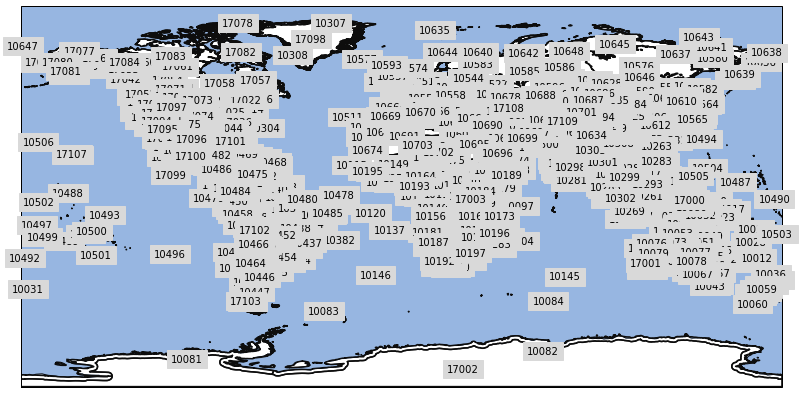

In [42]:
TerrEcos.plot()

## Marine Ecoregions Of the World
http://maps.tnc.org/gis_data.html
The Marine Ecoregions Of the World (MEOW) data set is a biogeographic classification of the world's coasts and shelves. The ecoregions nest within the broader biogeographic tiers of Realms and Provinces. Further details about the MEOW system and PDFs of the BioScience paper the comprehensive listing of sources are available from www.worldwildlife.org/MEOW/ and www.nature.org/MEOW.

In [43]:
# from http://maps.tnc.org/gis_data.html
#wget http://maps.tnc.org/files/shp/MEOW-TNC.zip

In [44]:
shp_file_str = 'MEOW-TNC/meow_ecos.shp'
MEOW_shp = geopandas.read_file(shp_file_str)
MEOW_shp.head()

,ECO_CODE,ECOREGION,PROV_CODE,PROVINCE,RLM_CODE,REALM,ALT_CODE,ECO_CODE_X,Lat_Zone,geometry
0,20192.0,Agulhas Bank,51.0,Agulhas,10.0,Temperate Southern Africa,189.0,192.0,Temperate,"POLYGON ((28.3599325705664 -36.64434819540219,..."
1,20053.0,Aleutian Islands,10.0,Cold Temperate Northeast Pacific,3.0,Temperate Northern Pacific,50.0,53.0,Temperate,(POLYGON ((-173.3941876832087 55.5980717299895...
2,20072.0,Amazonia,13.0,North Brazil Shelf,4.0,Tropical Atlantic,64.0,72.0,Tropical,POLYGON ((-41.13011585921021 0.473194719374873...
3,20194.0,Amsterdam-St Paul,52.0,Amsterdam-St Paul,10.0,Temperate Southern Africa,191.0,194.0,Temperate,POLYGON ((77.52994405801894 -34.52289747303172...
4,20228.0,Amundsen/Bellingshausen Sea,61.0,Continental High Antarctic,12.0,Southern Ocean,209.0,228.0,Polar,POLYGON ((-72.9422221975903 -74.30961632400209...


In [45]:
MEOW_mask = create_region_from_shapefile(MEOW_shp,name='MEOW',name_col='ECOREGION',number_col='ECO_CODE_X')

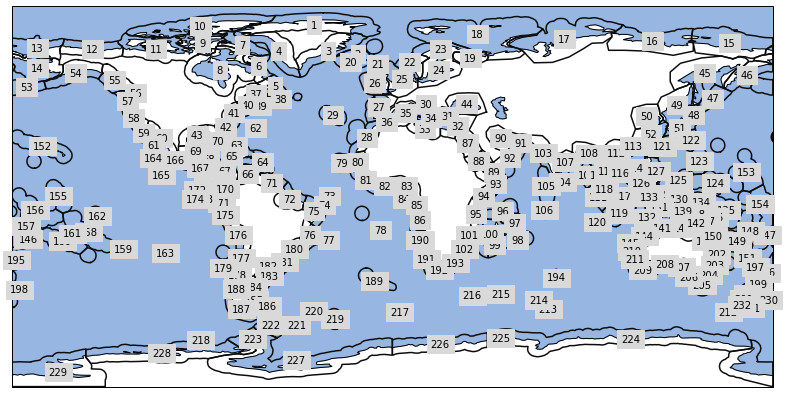

In [46]:
MEOW_mask.plot(label='number')

## Freshwater regions
The Freshwater Ecoregions Of the World (FEOW) provide a global biogeographic regionalization of the Earth's freshwater biodiversity. This version of the FEOW, modified by The Nature Conservancy, includes additional tabular data describing Major Habitat Types (MHTs, similar to terrestrial biomes, but unpublished).You can read more about the FEOW, and obtain the unmodified shapefile at www.feow.org.

In [47]:
# from http://maps.tnc.org/gis_data.html
# wget http://maps.tnc.org/files/shp/FEOW-TNC.zip

In [48]:
shp_file_str = 'FEOW-TNC/FEOWv1_TNC.shp'
FEOW_shp = geopandas.read_file(shp_file_str)
FEOW_shp.head()

,ECO_ID,ECOREGION,MHT_TXT,MHT_NO,OLD_ID,ECO_ID_U,geometry
0,103,Alaska & Canada Pacific Coastal,temperate coastal rivers,5,1.0,30103,(POLYGON ((-123.9380492399999 46.4311065960000...
1,120,Columbia Glaciated,temperate upland rivers,6,2.0,30120,POLYGON ((-114.1145126269999 48.99914736400007...
2,121,Columbia Unglaciated,temperate floodplain rivers and wetlands,7,3.0,30121,(POLYGON ((-123.5666732399999 46.2333297960000...
3,122,Upper Snake,temperate upland rivers,6,4.0,30122,POLYGON ((-111.1749992999999 44.56000065600006...
4,123,Oregon & Northern California Coastal,temperate coastal rivers,5,5.0,30123,(POLYGON ((-122.4072266399999 37.8613814760000...


In [49]:
FEOW_mask = create_region_from_shapefile(FEOW_shp,name='FEOW',name_col='ECOREGION',number_col='ECO_ID')

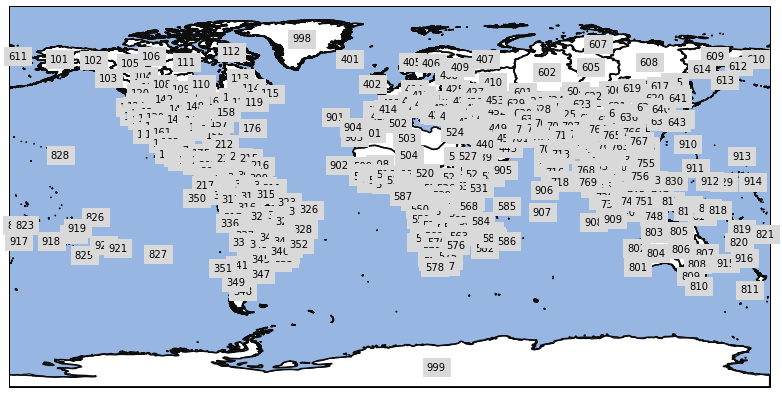

In [50]:
FEOW_mask.plot(label='number')